In [1]:
import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Importación y unión de datos

In [2]:
test_df = pd.read_spss(f"data/2022.sav")
test_df.head()

,AÑO,MES,DIASESTANCIA,SEXO,PPERTENENCIA,EDAD,PERIODOEDA,DEPTORESIDEN,MUNIRESIDEN,CAUFIN,CONDIEGRES,TRATARECIB
0,2022.0,Julio,1.0,Mujer,Ignorado,1.0,Meses,Huehuetenango,Huehuetenango,A010,Vivo,Médico
1,2022.0,Mayo,1.0,Mujer,Ignorado,1.0,Años,Guatemala,Mixco,A010,Vivo,Médico
2,2022.0,Abril,1.0,Mujer,Ignorado,1.0,Años,Suchitepéquez,San Antonio Suchitepéquez,A010,Vivo,Médico
3,2022.0,Enero,1.0,Hombre,Ignorado,1.0,Meses,Huehuetenango,Malacatancito,A010,Vivo,Médico
4,2022.0,Agosto,1.0,Mujer,"Mestizo, Ladino",3.0,Años,Izabal,Morales,A010,Vivo,Médico


In [3]:
dataframes = []
# Read each .sav file
# And concatenate all DataFrames into one
for year in range(2012, 2022):
    df = pd.read_spss(f"data/{year}.sav")
    if "GRUPETNICO" in df.columns:
        df.rename(columns={"GRUPETNICO": "PPERTENENCIA"}, inplace=True)
    dataframes.append(df)

merged_df = pd.concat(dataframes, ignore_index=True)
merged_df.head()

,AÑO,MES,DIASESTANCIA,SEXO,PPERTENENCIA,EDAD,PERIODOEDA,DEPTORESIDEN,MUNIRESIDEN,CAUFIN,CONDIEGRES,TRATARECIB
0,2012.0,Enero,1.0,Hombre,Ignorado,0.0,Días,Guatemala,San Juan Sacatepéquez,P95X,Vivo,Médico
1,2012.0,Febrero,1.0,Mujer,Ignorado,0.0,Días,Zacapa,Zacapa,P95X,Vivo,Médico
2,2012.0,Enero,2.0,Mujer,No indígena,0.0,Días,Quetzaltenango,Quetzaltenango,P95X,Vivo,Médico
3,2012.0,Abril,2.0,Mujer,No indígena,0.0,Días,Quetzaltenango,Quetzaltenango,P95X,Vivo,Médico
4,2012.0,Junio,2.0,Mujer,No indígena,0.0,Días,Quetzaltenango,Quetzaltenango,P95X,Vivo,Médico


# Análisis exploratorio
Queremos dirigir nuestro análisis exploratorio a contestar una serie de preguntas que nos pueden abrir paso a los diferentes acercamientos que podemos tomar para construir nuestro modelo para poder predecir la cantidad de días que una persona va a estar dentro de un hospital según la enfermedad que se le presenta. 

Para comenzar debemos de evaluar la calidad de los datos presentados por el Instituto Nacional de Estadística Guatemala (INE), estos datos podrían no estar en el mejor estado, presentando alta cantidad de valores nulos, datos poco íntegros o la variación que estos presentan según determinados grupos.

## Pre-Limpieza

### Corregir nombres y tipos de columnas

In [4]:
pprint.pprint(merged_df.columns)

Index(['AÑO', 'MES', 'DIASESTANCIA', 'SEXO', 'PPERTENENCIA', 'EDAD',
       'PERIODOEDA', 'DEPTORESIDEN', 'MUNIRESIDEN', 'CAUFIN', 'CONDIEGRES',
       'TRATARECIB'],
      dtype='object')


In [5]:

merged_df.columns = map(str.lower, merged_df.columns)
merged_df.rename(columns={
    "año":          "periodo",
    "diasestancia": "dias_estancia", 
    "ppertenencia": "grupo_etnico",
    "periodoeda":   "tipo_edad",
    "deptoresiden": "departamento",
    "muniresiden":  "municipio",
    "caufin":       "causa_atencion",
    "condiegres":   "condicion_egreso",
    "tratarecib":   "tratamiento_recibido"
}, inplace=True)
pprint.pprint(merged_df.columns)

Index(['periodo', 'mes', 'dias_estancia', 'sexo', 'grupo_etnico', 'edad',
       'tipo_edad', 'departamento', 'municipio', 'causa_atencion',
       'condicion_egreso', 'tratamiento_recibido'],
      dtype='object')


In [6]:
print(merged_df.dtypes)

periodo                  float64
mes                     category
dias_estancia             object
sexo                    category
grupo_etnico              object
edad                      object
tipo_edad               category
departamento            category
municipio                 object
causa_atencion            object
condicion_egreso          object
tratamiento_recibido      object
dtype: object


In [7]:
# See what are the 10 most frequent values for each of the dataframe columns
for column in merged_df.columns:
    frequency_values = merged_df[column].value_counts().head(10)
    print(f"\n=========================")
    print(frequency_values)



periodo
2019.0    286085
2020.0    261295
2016.0    250211
2018.0    238376
2015.0    234922
2021.0    228471
2017.0    223281
2014.0    207839
2013.0    189555
2012.0    185415
Name: count, dtype: int64

mes
Mayo          202504
Julio         198909
Marzo         198792
Agosto        198137
Octubre       194758
Septiembre    194122
Noviembre     189288
Junio         188916
Enero         188753
Abril         186462
Name: count, dtype: int64

dias_estancia
1.0         1266766
2.0          588640
3.0          202702
Ignorado      67542
4.0           61978
5.0           32733
6.0           19504
7.0           13047
8.0            8769
9.0            7219
Name: count, dtype: int64

sexo
Mujer       1398818
Hombre       900816
Ignorado       5816
Name: count, dtype: int64

grupo_etnico
Ignorado           847313
No indígena        592858
Mestizo, Ladino    580039
Indígena           171120
Maya               113385
Garífuna              543
Otro                  118
Xinca                  74

In [8]:
# True null values

# Numeric
# Any value that cannot be converted to numeric will be treated as null 
# (possibly if the "Ignorado" value is ever found).
merged_df["dias_estancia"] = pd.to_numeric(merged_df["edad"], errors="coerce")
merged_df["edad"] = pd.to_numeric(merged_df["edad"], errors="coerce")  
merged_df.loc[merged_df["edad"] > 9999, "edad"] = np.nan

# Category
merged_df["sexo"].replace("Ignorado", np.nan, inplace=True)
merged_df["grupo_etnico"].replace("Ignorado", np.nan, inplace=True)
merged_df["tipo_edad"].replace("Ignorado", np.nan, inplace=True)
merged_df["departamento"].replace("Ignorado", np.nan, inplace=True)
merged_df["municipio"].replace("Ignorado", np.nan, inplace=True)
merged_df["condicion_egreso"].replace("Ignorado", np.nan, inplace=True)
merged_df["tratamiento_recibido"].replace("Ignorado", np.nan, inplace=True)

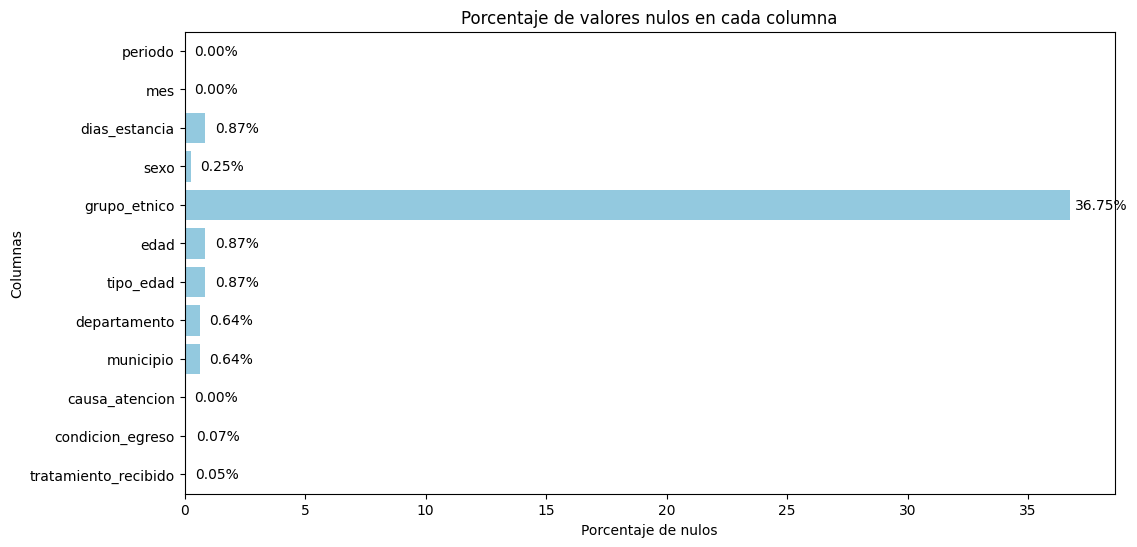

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the percentage of null values in each column
null_percentage = (merged_df.isnull().sum() / len(merged_df)) * 100

# Create a horizontal bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=null_percentage, y=null_percentage.index, color="skyblue")

# Add percentage in each bar
for p in ax.patches:
    percentage = '{:.2f}%'.format(p.get_width())
    x = p.get_x() + p.get_width() + 1.30
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), ha="center", va="center")

plt.xlabel("Porcentaje de nulos")
plt.ylabel("Columnas")
plt.title("Porcentaje de valores nulos en cada columna")


plt.show()